|Assessment Task 4.1|Supplementary Activity on Transfer Learning|
|-|-|
|Name|De Guzman, Aero Kent|
|Course Code & Section|CPE313 CPE32S3|
|Course Title|Advanced Machine Learning and Deep Learning|
|Date Performed|21/02/26|
|Date Submitted|23/02/26|
|Instructor|Engr. Neil Barton James Matira|

### **Instruction:**

* Perform Transfer Learning on PyTorch, afterwards perform transfer learning (either fine tuning or a feature extraction) on your chosen dataset.
* Take note of your experiment.
* Reach at least 95% test accuracy.

#### **libraries**

In [1]:
import torch.nn as nn
import torch.optim as optim
from torch.optim import lr_scheduler
import torch
import torchvision
from torchvision import datasets, models, transforms
import os
import time
from tempfile import TemporaryDirectory

#### **loading dataset and preparaing dataset**

https://www.kaggle.com/code/ahmedlashin/nike-adidas-converse-image-classification

In [ ]:
data_transforms = {
  'train': transforms.Compose([
    transforms.RandomResizedCrop(224),
    transforms.RandomHorizontalFlip(),
    transforms.ToTensor(),
    transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
  ]),
  'val': transforms.Compose([
    transforms.Resize(256),
    transforms.CenterCrop(224),
    transforms.ToTensor(),
    transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
  ]),
}

data_dir = '/content/drive/MyDrive/datasets/shoes_data'
image_datasets = {x: datasets.ImageFolder(os.path.join(data_dir, x),
                                          data_transforms[x])
                  for x in ['train', 'val']}
dataloaders = {x: torch.utils.data.DataLoader(image_datasets[x], batch_size=4,
                                             shuffle=True, num_workers=4)
              for x in ['train', 'val']}
dataset_sizes = {x: len(image_datasets[x]) for x in ['train', 'val']}
class_names = image_datasets['train'].classes

device = torch.accelerator.current_accelerator().type if torch.accelerator.is_available() else "cpu"
print(f"Using {device} device")

Using cuda device


/usr/local/lib/python3.12/dist-packages/torch/utils/data/dataloader.py:424: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  self.check_worker_number_rationality()


#### **preparing for training**

In [ ]:
def train_model(model, criterion, optimizer, scheduler, num_epochs=25):
  since = time.time()
  with TemporaryDirectory() as tempdir:
    best_model_params_path = os.path.join(tempdir, 'best_model_params.pt')

    torch.save(model.state_dict(), best_model_params_path)
    best_acc = 0.0

    for epoch in range(num_epochs):
      print(f'Epoch {epoch}/{num_epochs - 1}')
      print('-' * 10)

      for phase in ['train', 'val']:
        if phase == 'train':
          model.train()
        else:
          model.eval()

        running_loss = 0.0
        running_corrects = 0

        for inputs, labels in dataloaders[phase]:
          inputs = inputs.to(device)
          labels = labels.to(device)
          optimizer.zero_grad()

          with torch.set_grad_enabled(phase == 'train'):
            outputs = model(inputs)
            _, preds = torch.max(outputs, 1)
            loss = criterion(outputs, labels)

            if phase == 'train':
              loss.backward()
              optimizer.step()

          running_loss += loss.item() * inputs.size(0)
          running_corrects += torch.sum(preds == labels.data)
        if phase == 'train':
          scheduler.step()

        epoch_loss = running_loss / dataset_sizes[phase]
        epoch_acc = running_corrects.double() / dataset_sizes[phase]

        print(f'{phase} Loss: {epoch_loss:.4f} Acc: {epoch_acc:.4f}')

        if phase == 'val' and epoch_acc > best_acc:
          best_acc = epoch_acc
          torch.save(model.state_dict(), best_model_params_path)

      print()

    time_elapsed = time.time() - since
    print(f'Training complete in {time_elapsed // 60:.0f}m {time_elapsed % 60:.0f}s')
    print(f'Best val Acc: {best_acc:4f}')

    model.load_state_dict(torch.load(best_model_params_path, weights_only=True))
  return model

#### **training**

In [ ]:
model = models.densenet169(weights='IMAGENET1K_V1')
num_ftrs = model.classifier.in_features
model.classifier = nn.Linear(num_ftrs, len(class_names))
model = model.to(device)
criterion = nn.CrossEntropyLoss()
# optimizer_ft = optim.SGD(model.parameters(), lr=0.0001, momentum=0.9)
optimizer_ft = optim.AdamW(model.parameters(), lr=0.00001, weight_decay=1e-4)
exp_lr_scheduler = lr_scheduler.StepLR(optimizer_ft, step_size=7, gamma=0.1)

In [ ]:
model = train_model(model, criterion, optimizer_ft, exp_lr_scheduler,
                    num_epochs = 25)

Epoch 0/24
----------


/usr/local/lib/python3.12/dist-packages/torch/utils/data/dataloader.py:432: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  self.check_worker_number_rationality()


train Loss: 1.0522 Acc: 0.4613
val Loss: 0.9070 Acc: 0.6667

Epoch 1/24
----------
train Loss: 0.8912 Acc: 0.6484
val Loss: 0.7531 Acc: 0.6930

Epoch 2/24
----------
train Loss: 0.7489 Acc: 0.7328
val Loss: 0.5607 Acc: 0.8070

Epoch 3/24
----------
train Loss: 0.6480 Acc: 0.7623
val Loss: 0.4395 Acc: 0.8684

Epoch 4/24
----------
train Loss: 0.5786 Acc: 0.7679
val Loss: 0.3757 Acc: 0.8860

Epoch 5/24
----------
train Loss: 0.5223 Acc: 0.7975
val Loss: 0.3484 Acc: 0.8860

Epoch 6/24
----------
train Loss: 0.5247 Acc: 0.8073
val Loss: 0.2833 Acc: 0.9123

Epoch 7/24
----------
train Loss: 0.4654 Acc: 0.8256
val Loss: 0.3112 Acc: 0.8860

Epoch 8/24
----------
train Loss: 0.4770 Acc: 0.8031
val Loss: 0.2822 Acc: 0.9035

Epoch 9/24
----------
train Loss: 0.4818 Acc: 0.8115
val Loss: 0.2662 Acc: 0.9298

Epoch 10/24
----------
train Loss: 0.4655 Acc: 0.8214
val Loss: 0.2429 Acc: 0.9386

Epoch 11/24
----------
train Loss: 0.4829 Acc: 0.8129
val Loss: 0.2485 Acc: 0.9298

Epoch 12/24
----------
t

**test 0:** using densenet161 with crossentropyloss, sdg with 0.0001 learning rate and 0.9 momentum, learning rate scheduler with 7 step sizes and 0.1 gamma, and 20 epochs: it achieved a best validation **accuracy of 0.921053** in 9m 14s

**test 1:** using same as test 0 but 6 step sizes and 25 epochs: it achieved a
best validation **accuracy of 0.903509** in 10m 26s

**test 2:** using same as test 0 but 25 epochs and added weight decay 1e-4: it achieved a best validation **accuracy of 0.885965** in 10m 37s

**test 3:** using same as test 0 but 25 epochs: it achieved a best validation  **accuracy of 0.912281** in 10m 32s

**test 4:** using same as test 3 but with densenet169: it achieved a best validation  **accuracy of 0.947368** in 9m 1s

**test 5** using same as test 4 but with AdamW using 0.00001 learning rate and 1e-4 weight decay: it achieved a best validation  **accuracy of 0.956140** in 9m 17s

#### **visualization of output**

*not needed but just to see that the classification is working properly*

In [ ]:
import matplotlib.pyplot as plt

def visualize_model(model, num_images=6):
  was_training = model.training
  model.eval()
  images_so_far = 0
  fig = plt.figure()

  with torch.no_grad():
    for i, (inputs, labels) in enumerate(dataloaders['val']):
      inputs = inputs.to(device)
      labels = labels.to(device)

      outputs = model(inputs)
      _, preds = torch.max(outputs, 1)

      for j in range(inputs.size()[0]):
        images_so_far += 1
        ax = plt.subplot(num_images//2, 2, images_so_far)
        ax.axis('off')
        ax.set_title(f'predicted: {class_names[preds[j]]}')
        img = inputs.cpu().data[j].permute(1, 2, 0)
        plt.imshow(img)

        if images_so_far == num_images:
          model.train(mode=was_training)
          return
    model.train(mode=was_training)

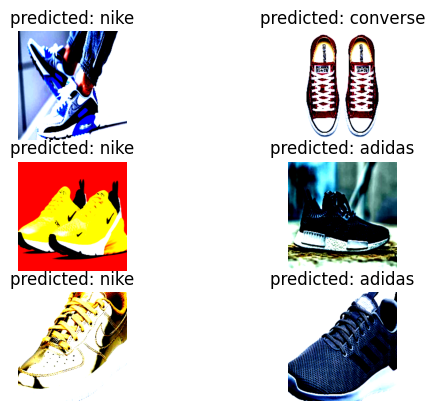

In [ ]:
visualize_model(model)
plt.show()

#### **conclusion**

In [ ]:
# to conclude the following activity, it is simply the second supplementary
# activity that shares similar goal as to the previous activity just before this
# which is to apply a pretrained model then achieve a 0.95 validation accuracy.
#
# the only difference is that a different dataset is used here instead which is
# a shoes dataset the I have sourced from kaggle containing three labels which
# are nike, adidas, and converse. In here after properly importing the dataset
# as well as configuring the function for the training loop for training, the
# data is trained using the densenet model specifically the densenet 169 and 161.
# initially the densenet169 is the one used here but i was able to only get it
# as far as 0.9474 in validation accuracy which could be acceptable and meets
# the requirements now of 0.95 validation accuracy if it is rounded off only so
# instead I used the densenet161 model which after using similar but differing
# optimizer which is adamw i was able to push it to 0.9561 in validation accuracy.